# Examen 3 Práctico
## Arantza Gomez Haro Gamboa

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import roc_curve

In [33]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos:**

In [34]:
df = pd.read_csv('hr_role.csv')
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df)

target = 'Attrition'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Árbol Max Depth 2**

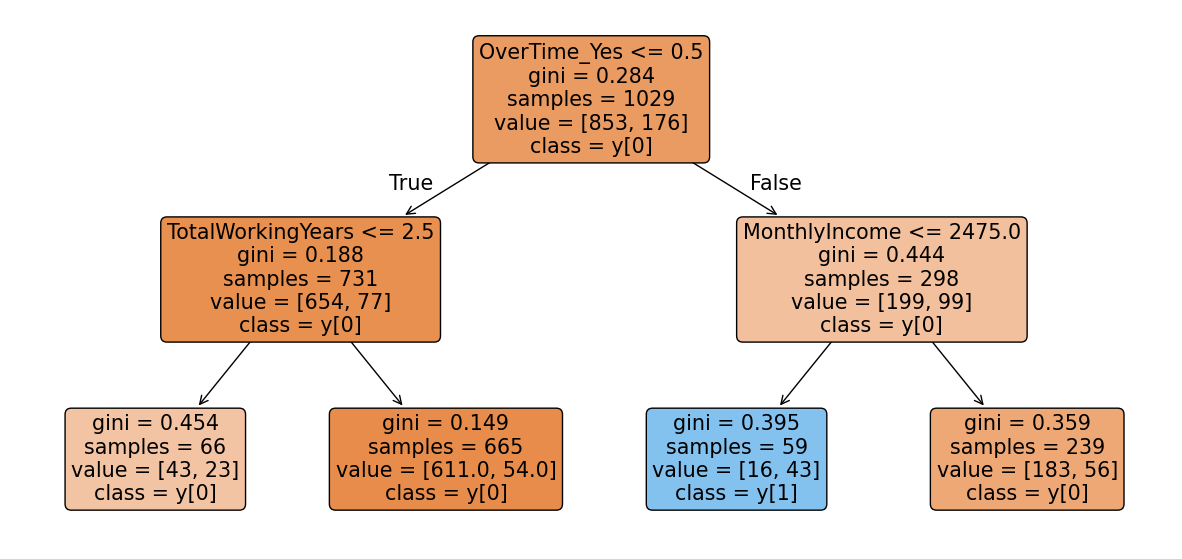

In [36]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
plt.figure(figsize=(15, 7))
plot_tree(tree, feature_names=X.columns, filled = True, rounded = True, class_names=True)
plt.show()

##### *Análisis:*

### **Mejor Árbol**

In [37]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier())
])

params = {
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13],
    'tree__min_samples_split': [2,3,4,5,6,7,8,9,10],
    'tree__min_samples_leaf': [1,2,3,4,5],
    'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5]
}

grid_tree = GridSearchCV(estimator = pipeline, cv=5, n_jobs=-1, scoring = 'roc_auc', param_grid = params)
grid_tree.fit(X_train, y_train)

c:\Users\arant\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13],
                         'tree__max_features': ['log2', 'sqrt', 1, 2, 3, 4, 5],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='roc_auc')

In [38]:
grid_tree.best_params_

{'tree__max_depth': 6,
 'tree__max_features': 5,
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 3}

In [39]:
best_model = grid_tree.best_estimator_.named_steps['tree']
predicciones = best_model.predict_proba(X_test)[:,1]
auc_dtc = roc_auc_score(y_score=predicciones, y_true=y_test)

##### *Feature Importance:*

In [40]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
51,OverTime_No,0.231454
7,JobLevel,0.211253
46,JobRole_Sales Representative,0.048697
2,DistanceFromHome,0.045649
20,YearsInCurrentRole,0.043940
15,StockOptionLevel,0.042576
19,YearsAtCompany,0.042264
8,MonthlyIncome,0.041483
49,MaritalStatus_Single,0.031139
5,HourlyRate,0.028716


##### *Análisis:*

### **Modelos:**

#### Random Forest

In [41]:
len(X_train.keys())

53

In [42]:
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs = -1))
])

params = {
    'rf__max_depth': [20, 25, 20, 35, 40],
    'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs = -1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20, 25, 20, 35, 40],
                         'rf__max_features': ['log2', 'sqrt', 35, 40, 45, 53]},
             scoring='roc_auc')

In [43]:
rf_grid.best_params_

{'rf__max_depth': 20, 'rf__max_features': 'log2'}

In [44]:
best_model =rf_grid.best_estimator_.named_steps['rf']
predicciones_rf = best_model.predict(X_test)
auc_rf = roc_auc_score(y_score=predicciones_rf, y_true=y_test)

##### *Feature Importance:*

In [45]:
importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': best_model.feature_importances_
})

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.071831
0,Age,0.060774
16,TotalWorkingYears,0.050081
1,DailyRate,0.046434
9,MonthlyRate,0.043062
19,YearsAtCompany,0.042700
2,DistanceFromHome,0.041712
5,HourlyRate,0.040979
10,NumCompaniesWorked,0.036416
51,OverTime_No,0.036266


##### *Análisis:*

#### XGBoost:

In [46]:
model = XGBRegressor(
    n_estimators = 100000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 500
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:0.36244	validation_1-rmse:0.34322
[100]	validation_0-rmse:0.11245	validation_1-rmse:0.32416


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:06:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:0.05259	validation_1-rmse:0.32666
[300]	validation_0-rmse:0.02487	validation_1-rmse:0.32874
[400]	validation_0-rmse:0.01271	validation_1-rmse:0.32858
[500]	validation_0-rmse:0.00622	validation_1-rmse:0.32871
[525]	validation_0-rmse:0.00530	validation_1-rmse:0.32880


XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=500, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

In [47]:
predicciones_xg = model.predict(X_test)
auc_xg = roc_auc_score(y_score=predicciones_xg, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

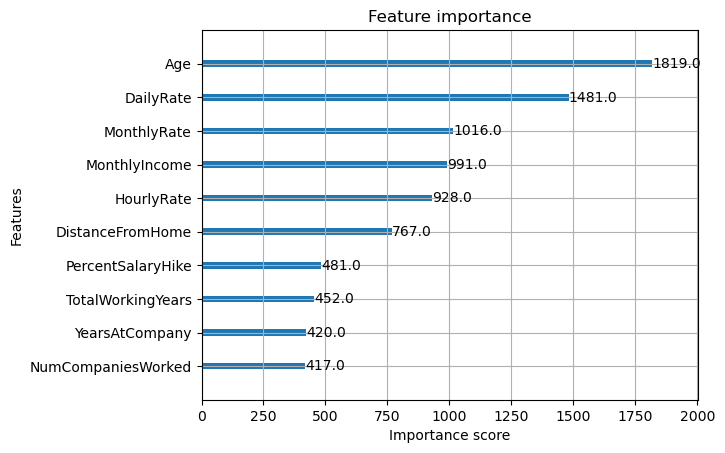

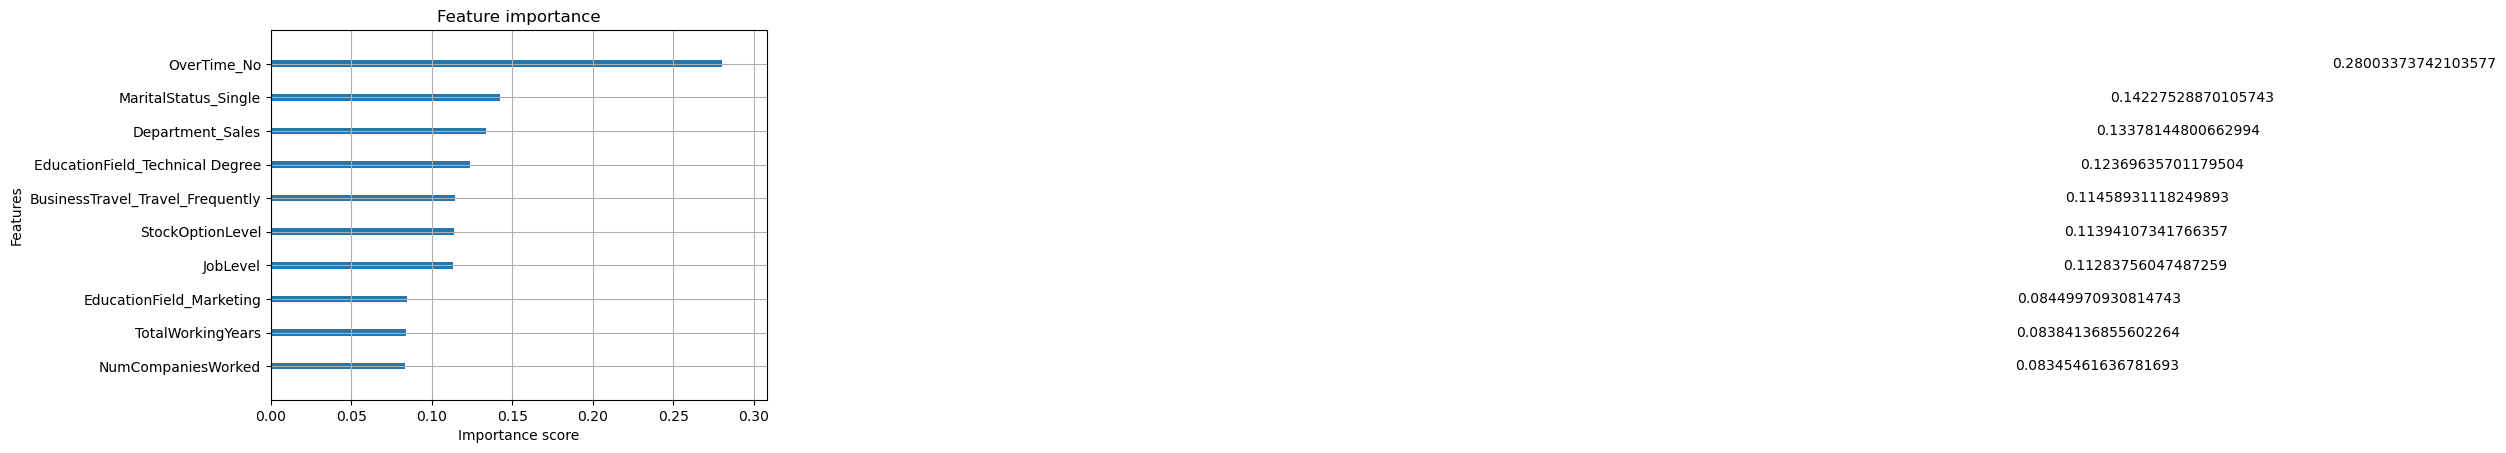

In [48]:
plot_importance(model, max_num_features=10, importance_type="weight")
plot_importance(model, max_num_features=10, importance_type="gain")

#### LightGBM:

In [49]:
model = LGBMRegressor(
    n_estimators=100000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(40),
                     log_evaluation(100)])

Training until validation scores don't improve for 40 rounds
[100]	training's rmse: 0.201153	training's l2: 0.0404625	valid_1's rmse: 0.311397	valid_1's l2: 0.0969684
Early stopping, best iteration is:
[64]	training's rmse: 0.228152	training's l2: 0.0520533	valid_1's rmse: 0.308998	valid_1's l2: 0.0954797


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
              n_estimators=100000, num_leaves=10, subsample=0.8, verbosity=-1)

In [50]:
predicciones_light = model.predict(X_test)
auc_light = roc_auc_score(y_score=predicciones_light, y_true=y_test)

##### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

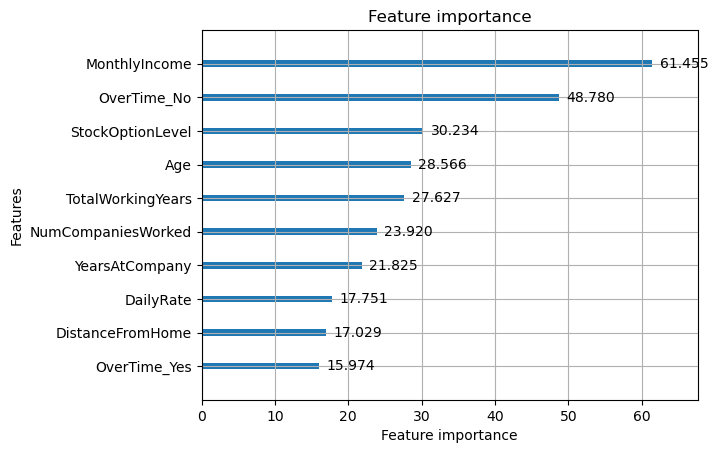

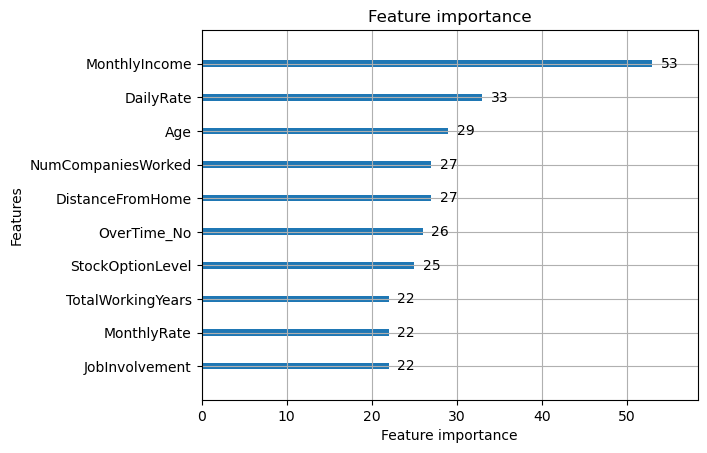

In [51]:
lgb.plot_importance(model, max_num_features = 10, importance_type='gain')
lgb.plot_importance(model, max_num_features = 10, importance_type='split')

#### CatBoost

In [52]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [53]:
model = CatBoostRegressor(
    iterations=10_000,         
    depth=5,                   
    learning_rate=0.1,
    subsample=0.5,             
    rsm=0.8,                  
    eval_metric='R2',
    early_stopping_rounds=40,
    verbose = 100)           

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

predicciones_catboost = model.predict(X_test)
auc_cat = roc_auc_score(y_score=predicciones_catboost, y_true=y_test)

0:	learn: 0.0357798	test: 0.0058630	best: 0.0058630 (0)	total: 27.2ms	remaining: 4m 32s
100:	learn: 0.5013305	test: 0.1822819	best: 0.1822819 (100)	total: 4.14s	remaining: 6m 46s
200:	learn: 0.6149775	test: 0.2128002	best: 0.2129720 (199)	total: 8.1s	remaining: 6m 35s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.2188525858
bestIteration = 220

Shrink model to first 221 iterations.


In [54]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

importancias.sort_values('importancia', ascending = False, inplace = True)
importancias.head(10)

,variables,importancia
8,MonthlyIncome,0.071831
0,Age,0.060774
16,TotalWorkingYears,0.050081
1,DailyRate,0.046434
9,MonthlyRate,0.043062
19,YearsAtCompany,0.042700
2,DistanceFromHome,0.041712
5,HourlyRate,0.040979
10,NumCompaniesWorked,0.036416
51,OverTime_No,0.036266


### **Gráficas de Calibración:**

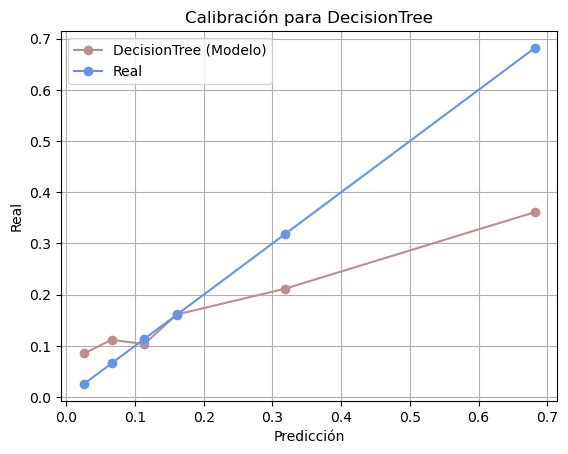

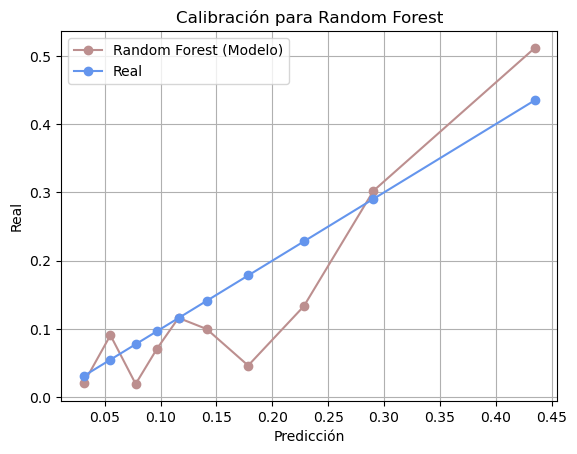

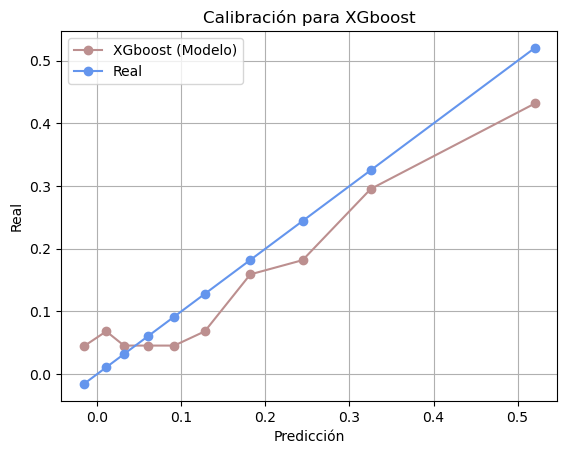

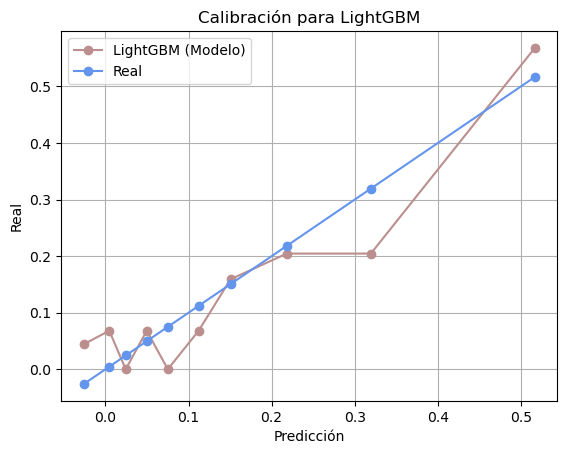

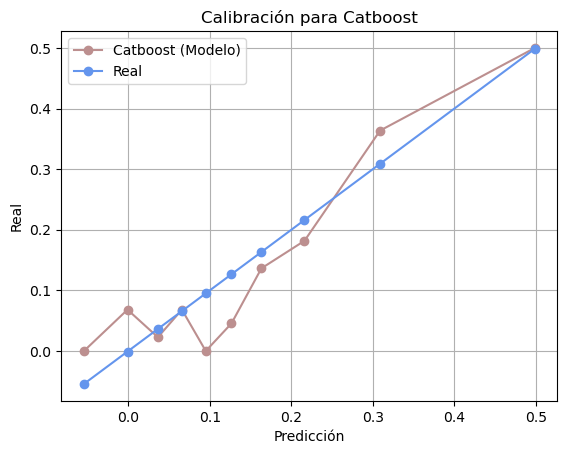

In [55]:
modelos = {
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGboost': predicciones_xg,
    'LightGBM': predicciones_light,
    'Catboost': predicciones_catboost,
}

calibracion_multiple(modelos, y_test, bins=10)

### **Histogramas:**

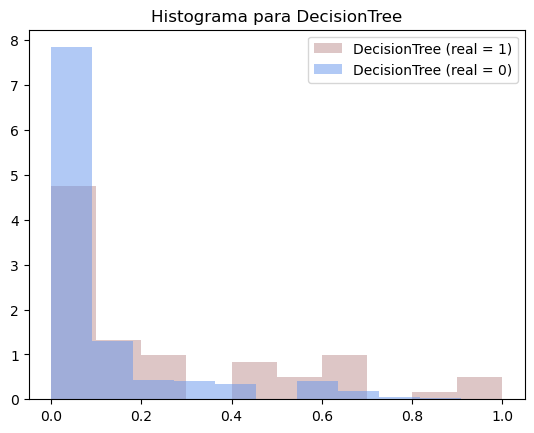

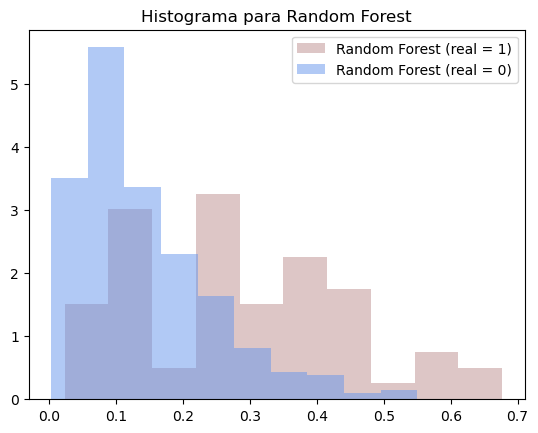

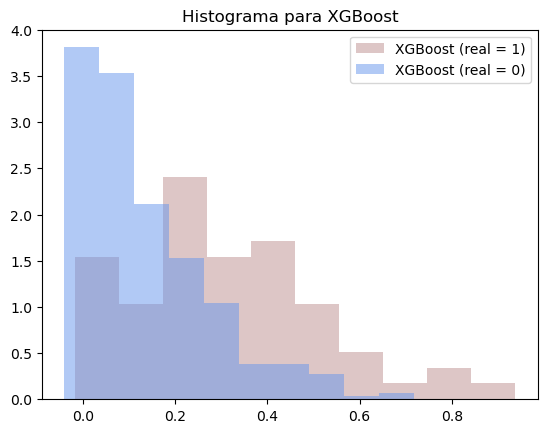

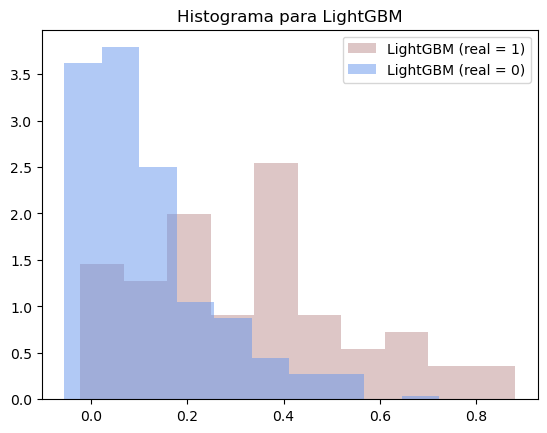

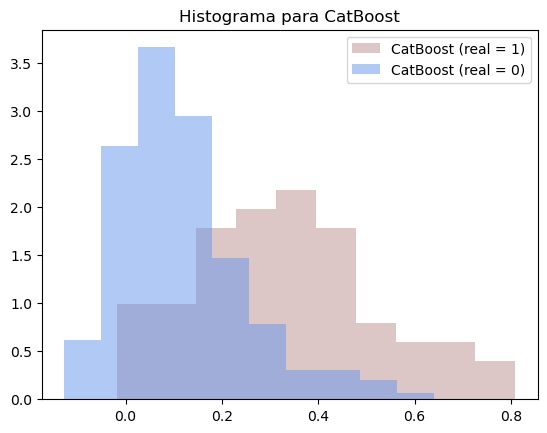

In [56]:
histogramas = pd.DataFrame({
    'real': y_test,
    'DecisionTree': predicciones,
    'Random Forest': predicciones_rf,
    'XGBoost': predicciones_xg,
    'LightGBM': predicciones_light,
    'CatBoost': predicciones_catboost,
})

real1 = histogramas[histogramas['real'] == 1]
real0 = histogramas[histogramas['real'] == 0]

modelos = ['DecisionTree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

for modelo in modelos:
    plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='rosybrown', label=f'{modelo} (real = 1)')
    plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='cornflowerblue', label=f'{modelo} (real = 0)')
    plt.title(f'Histograma para {modelo}')
    plt.legend()
    plt.show()

### **Curva ROC:**

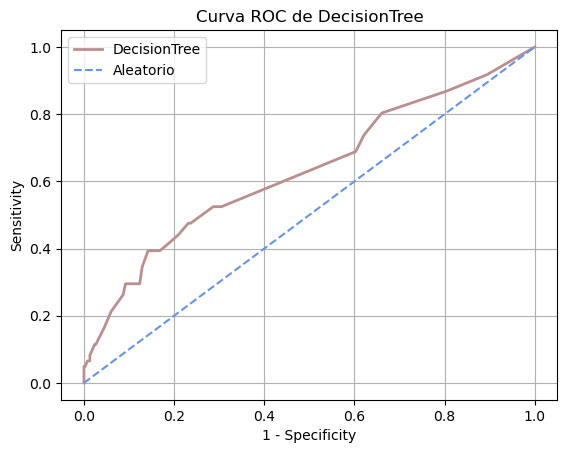

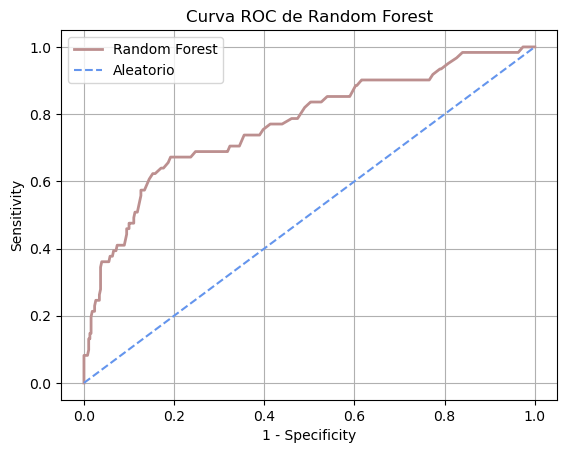

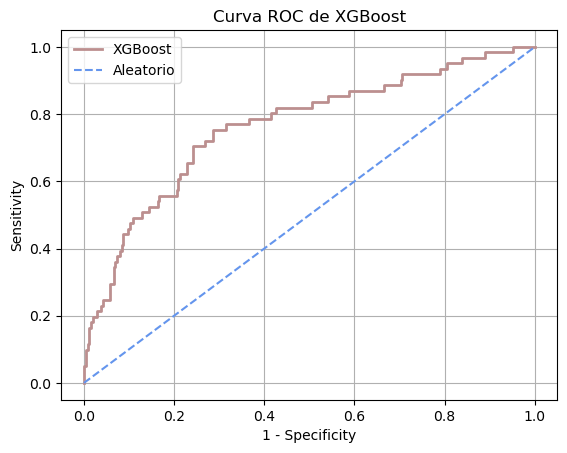

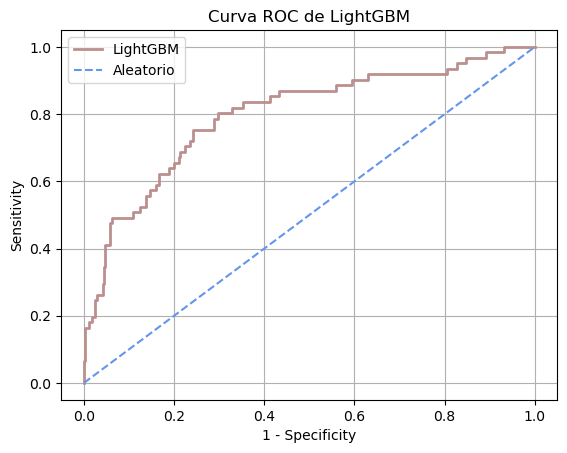

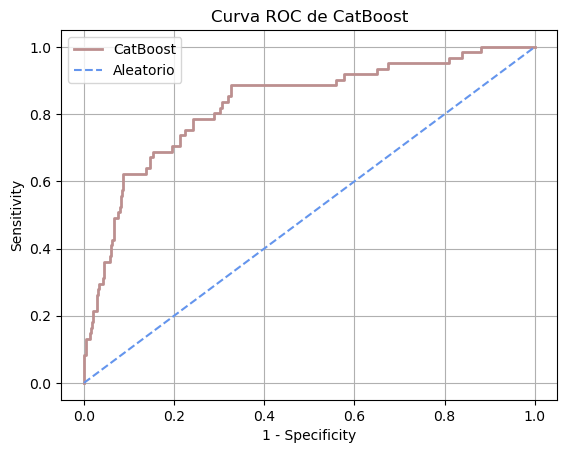

In [57]:

resultados = [predicciones, predicciones_rf, predicciones_xg, predicciones_light, predicciones_catboost]

for i, modelo in enumerate(modelos):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='rosybrown', lw=2)
    plt.plot([0, 1], [0, 1], color='cornflowerblue', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

### **AUC:**

In [58]:
tabla = pd.DataFrame({
    'DecisionTree': auc_dtc,
    'Random Forest': auc_rf,
    'XGBoost': auc_xg,
    'LightGBM': auc_light,
    'CatBoost': auc_cat
}, index=['AUC'])
tabla

,DecisionTree,Random Forest,XGBoost,LightGBM,CatBoost
AUC,0.631816,0.771484,0.765099,0.799439,0.82994
